In [7]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Import csv file 
data = pd.read_csv("../../housing.csv")

In [9]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [10]:
# inspect the first 5 rows of the dataset
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Reduce the columns to seemingly relevant ones (using domain knowledge)

In [11]:
selected_columns = [
    'SalePrice', 'LotArea', 'Neighborhood', 'HouseStyle', 'YearBuilt', 
    'YearRemodAdd', 'Heating', 'CentralAir', 'TotRmsAbvGrd', 'FullBath', 
    'HalfBath', 'GrLivArea', 'GarageCars', 'PoolArea', 'OpenPorchSF'
]

reduced_df = data[selected_columns]


In [12]:
# Clean selected columns if necessary
#create df with selected columns only
df_selected_columns = data[selected_columns]

# Check for missing values
missing_values = df_selected_columns.isnull().sum()
print("Missing values in selected columns:\n", missing_values)

Missing values in selected columns:
 SalePrice       0
LotArea         0
Neighborhood    0
HouseStyle      0
YearBuilt       0
YearRemodAdd    0
Heating         0
CentralAir      0
TotRmsAbvGrd    0
FullBath        0
HalfBath        0
GrLivArea       0
GarageCars      0
PoolArea        0
OpenPorchSF     0
dtype: int64


In [13]:
# Create table
data = df_selected_columns.copy()

def format_example_values(series):
    vals = series.dropna().unique()[:5]
    
    formatted = []
    for v in vals:
        if isinstance(v, (int, float, np.number)):
            formatted.append(f"{v:.2f}")
        else:
            formatted.append(str(v))
    return ", ".join(formatted)

summary_df = pd.DataFrame({
    "Feature/variable": data.columns,
    "Data type": data.dtypes.values.astype(str),
    "Description": [""] * len(data.columns),
    "Number of Unique values": [data[col].nunique() for col in data.columns],
    "Example values": [format_example_values(data[col]) for col in data.columns]
})

# Show all rows without truncation
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    print(summary_df.to_markdown(index=False))


| Feature/variable   | Data type   | Description   |   Number of Unique values | Example values                                        |
|:-------------------|:------------|:--------------|--------------------------:|:------------------------------------------------------|
| SalePrice          | int64       |               |                       663 | 208500.00, 181500.00, 223500.00, 140000.00, 250000.00 |
| LotArea            | int64       |               |                      1073 | 8450.00, 9600.00, 11250.00, 9550.00, 14260.00         |
| Neighborhood       | object      |               |                        25 | CollgCr, Veenker, Crawfor, NoRidge, Mitchel           |
| HouseStyle         | object      |               |                         8 | 2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer                |
| YearBuilt          | int64       |               |                       112 | 2003.00, 1976.00, 2001.00, 1915.00, 2000.00           |
| YearRemodAdd       | int64       |     

In [14]:
# Check data types
print("\nData types of selected columns:\n", df_selected_columns.dtypes)


Data types of selected columns:
 SalePrice        int64
LotArea          int64
Neighborhood    object
HouseStyle      object
YearBuilt        int64
YearRemodAdd     int64
Heating         object
CentralAir      object
TotRmsAbvGrd     int64
FullBath         int64
HalfBath         int64
GrLivArea        int64
GarageCars       int64
PoolArea         int64
OpenPorchSF      int64
dtype: object


In [15]:
# Split into numeric and categorical columns
numeric_cols = reduced_df.select_dtypes(include=[np.number]).columns.tolist()
#drop taret variable from numeric cols
numeric_cols.remove('SalePrice')
categorical_cols = reduced_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['LotArea', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'FullBath', 'HalfBath', 'GrLivArea', 'GarageCars', 'PoolArea', 'OpenPorchSF']
Categorical columns: ['Neighborhood', 'HouseStyle', 'Heating', 'CentralAir']


In [16]:
# Create table for numeric columns
# numeric variables only (target + predictors)

# Basic descriptive statistics
desc = data[numeric_cols].describe().rename(index={
    "50%": "50%",
    "25%": "25%",
    "75%": "75%"
})

# Add variance
desc.loc["Variance"] = data[numeric_cols].var()

# Add dispersion index = variance / mean
dispersion_index = data[numeric_cols].var() / data[numeric_cols].mean()
desc.loc["Dispersion index (Variance / Mean)"] = dispersion_index

# Reorder rows to match your required format
row_order = [
    "count", "mean", "std", "min", "25%", "50%", "75%", "max",
    "Variance", "Dispersion index (Variance / Mean)"
]
desc = desc.loc[row_order]

# Convert to Markdown
md_table = desc.to_markdown(tablefmt="pipe", floatfmt=".3f")
print(md_table)

|                                    |      LotArea |   YearBuilt |   YearRemodAdd |   TotRmsAbvGrd |   FullBath |   HalfBath |   GrLivArea |   GarageCars |   PoolArea |   OpenPorchSF |
|:-----------------------------------|-------------:|------------:|---------------:|---------------:|-----------:|-----------:|------------:|-------------:|-----------:|--------------:|
| count                              |     1460.000 |    1460.000 |       1460.000 |       1460.000 |   1460.000 |   1460.000 |    1460.000 |     1460.000 |   1460.000 |      1460.000 |
| mean                               |    10516.828 |    1971.268 |       1984.866 |          6.518 |      1.565 |      0.383 |    1515.464 |        1.767 |      2.759 |        46.660 |
| std                                |     9981.265 |      30.203 |         20.645 |          1.625 |      0.551 |      0.503 |     525.480 |        0.747 |     40.177 |        66.256 |
| min                                |     1300.000 |    1872.000 |   

In [17]:
# Descriptive table for categorical variables

cat_desc = pd.DataFrame(index=categorical_cols, columns=[
    "Unique Values", "Most Frequent", "Frequency", "Percentage"
])

for col in categorical_cols:
    counts = data[col].value_counts(dropna=False)
    most_freq_val = counts.idxmax()
    freq = counts.max()
    perc = freq / counts.sum() * 100

    cat_desc.loc[col] = [
        data[col].nunique(),
        most_freq_val,
        freq,
        perc
    ]

# Convert to Markdown
md_table_cat = cat_desc.to_markdown(tablefmt="pipe", floatfmt=".2f")
print(md_table_cat)

|              |   Unique Values | Most Frequent   |   Frequency |   Percentage |
|:-------------|----------------:|:----------------|------------:|-------------:|
| Neighborhood |              25 | NAmes           |         225 |        15.41 |
| HouseStyle   |               8 | 1Story          |         726 |        49.73 |
| Heating      |               6 | GasA            |        1428 |        97.81 |
| CentralAir   |               2 | Y               |        1365 |        93.49 |


In [18]:
# Check multicollinearity (VIF) for numeric variables
vif_df = pd.DataFrame()
vif_df['feature'] = numeric_cols
vif_df['VIF'] = [variance_inflation_factor(reduced_df[numeric_cols].values, i) 
                 for i in range(len(numeric_cols))]

print("\nVariance Inflation Factors (numeric predictors):")
print(vif_df.sort_values('VIF', ascending=False))


Variance Inflation Factors (numeric predictors):
        feature          VIF
1     YearBuilt  8153.704734
2  YearRemodAdd  8097.332297
3  TotRmsAbvGrd    55.269870
6     GrLivArea    44.075356
4      FullBath    18.370616
7    GarageCars    10.111274
0       LotArea     2.322336
5      HalfBath     2.131757
9   OpenPorchSF     1.714965
8      PoolArea     1.060630


/var/folders/x_/zccbsk657rb51hx1tc0t1ss80000gn/T/ipykernel_61802/2492064205.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")


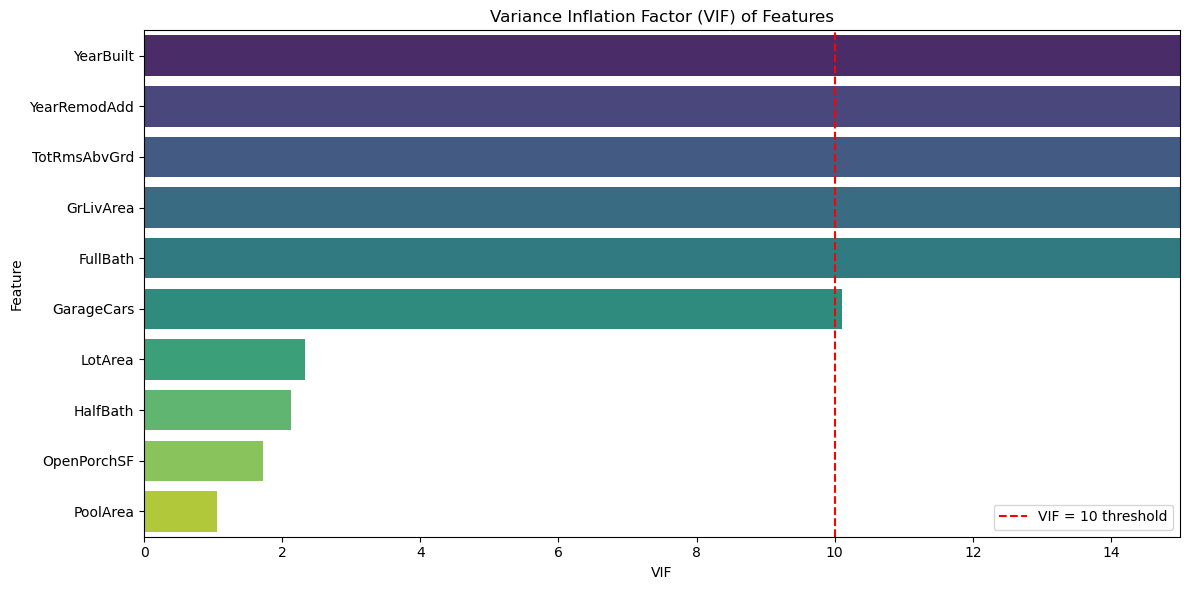

In [19]:
# Sort VIFs descending for better visualization
vif_sorted = vif_df.sort_values("VIF", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 threshold')
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Variance Inflation Factor (VIF) of Features")
plt.xlim(0, 15)  # Set x-axis scale from 0 to 15
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
# Chi-square test for categorical variables
chi2_results = []

for var1, var2 in combinations(categorical_cols, 2):
    table = pd.crosstab(reduced_df[var1], reduced_df[var2])
    chi2, p, dof, _ = chi2_contingency(table)
    chi2_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Chi2': chi2,
        'p-value': p
    })

chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

print("\nChi-Square Test Results (categorical predictors):")
print(chi2_df.to_markdown(index=False))


Chi-Square Test Results (categorical predictors):
| Variable 1   | Variable 2   |      Chi2 |      p-value |
|:-------------|:-------------|----------:|-------------:|
| Neighborhood | HouseStyle   | 1047.26   | 5.59656e-127 |
| Heating      | CentralAir   |  314.83   | 6.4817e-66   |
| Neighborhood | CentralAir   |  237.084  | 5.90334e-37  |
| HouseStyle   | Heating      |  180.295  | 1.81955e-21  |
| HouseStyle   | CentralAir   |   86.3752 | 6.85415e-16  |
| Neighborhood | Heating      |  141.109  | 0.0913586    |


Here, numeric predictors >10 indicate multicollinarity. Therefore, we can drop some of the columns.


Housing Style and Neighborhood -> Chi-square test showed a very strong association, indicating "multicollinearity"
By dropping HouseStyle and keeping Neighborhood, we remove this redundancy.
Heating vs CentralAir ->Strong association only Heating (as Iowa is a cold state) avoids multicollinearity.


In [21]:
reduced_cols = [
    'LotArea',
    'YearBuilt',
    'GrLivArea',
    'FullBath',
    'HalfBath',
    'OpenPorchSF',
    'PoolArea',
    'Neighborhood',
    'Heating',
    'SalePrice'
]

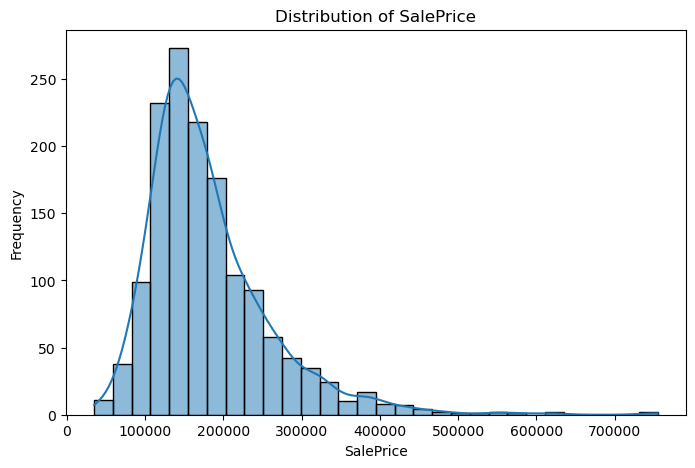

In [22]:
# Check some distributions
# SalesPrice distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(reduced_df['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


In [23]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(reduced_df[reduced_cols], test_size=0.2, random_state=42)
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")

Training set size: (1168, 10)
Validation set size: (292, 10)


In [24]:
# Run GLM model
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath + OpenPorchSF + PoolArea + C(Neighborhood) + C(Heating)'
glm_model = smf.glm(formula=formula, data=train_df, family=sm.families.Gaussian()).fit()
print(glm_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1131
Model Family:                Gaussian   Df Model:                           36
Link Function:               Identity   Scale:                      1.4771e+09
Method:                          IRLS   Log-Likelihood:                -13969.
Date:                Mon, 15 Dec 2025   Deviance:                   1.6706e+12
Time:                        21:55:08   Pearson chi2:                 1.67e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9536
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [25]:
# Create a DataFrame with the model statistics: Deviance, Null Deviance, Deviance Explained, Log_likelihood, AIC
model_stats = {
    'Deviance': round(glm_model.deviance,2),
    'Null Deviance': round(glm_model.null_deviance,2),
    'Deviance Explained': (glm_model.null_deviance - glm_model.deviance) / glm_model.null_deviance,
    'Log-Likelihood': round(glm_model.llf,2),
    'AIC': round(glm_model.aic,2)
}
print(model_stats)

{'Deviance': np.float64(1670569103528.05), 'Null Deviance': np.float64(6966594843571.94), 'Deviance Explained': np.float64(0.7602029196416557), 'Log-Likelihood': np.float64(-13968.7), 'AIC': np.float64(28011.41)}


In [26]:
# Create a df with predictor coefficients, std errors, z-values, p-values, conf intervals
coeff_summary = glm_model.summary2().tables[1]
print("\nGLM Coefficients Summary:")
print(coeff_summary)


GLM Coefficients Summary:
                                   Coef.       Std.Err.          z  \
Intercept                  -1.481075e+06  168435.296137  -8.793137   
C(Neighborhood)[T.Blueste] -3.044383e+04   39886.865665  -0.763254   
C(Neighborhood)[T.BrDale]  -3.834704e+04   15158.101587  -2.529805   
C(Neighborhood)[T.BrkSide] -1.999003e+03   12969.369210  -0.154133   
C(Neighborhood)[T.ClearCr]  6.357771e+03   14128.247199   0.450004   
C(Neighborhood)[T.CollgCr]  4.474545e+03   10670.477518   0.419339   
C(Neighborhood)[T.Crawfor]  3.384578e+04   12653.798902   2.674752   
C(Neighborhood)[T.Edwards] -2.739170e+04   11492.860922  -2.383367   
C(Neighborhood)[T.Gilbert] -9.300358e+03   11261.796494  -0.825833   
C(Neighborhood)[T.IDOTRR]  -1.426860e+04   13971.777382  -1.021245   
C(Neighborhood)[T.MeadowV] -4.533908e+04   16058.459342  -2.823377   
C(Neighborhood)[T.Mitchel] -1.694397e+04   11902.709448  -1.423539   
C(Neighborhood)[T.NAmes]   -9.425165e+03   11115.670015  -0.847

In [27]:
# Remove pool area from model and rerun
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath + OpenPorchSF + C(Neighborhood) + C(Heating)'
glm_model = smf.glm(formula=formula, data=train_df, family=sm.families.Gaussian()).fit()
print(glm_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1132
Model Family:                Gaussian   Df Model:                           35
Link Function:               Identity   Scale:                      1.4758e+09
Method:                          IRLS   Log-Likelihood:                -13969.
Date:                Mon, 15 Dec 2025   Deviance:                   1.6706e+12
Time:                        21:55:10   Pearson chi2:                 1.67e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9537
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [28]:
# Remove heating as the entire variable has no significant p-values
# Remove pool area from model and rerun
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath + OpenPorchSF + C(Neighborhood)'
glm_model = smf.glm(formula=formula, data=train_df, family=sm.families.Gaussian()).fit()
print(glm_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1137
Model Family:                Gaussian   Df Model:                           30
Link Function:               Identity   Scale:                      1.4754e+09
Method:                          IRLS   Log-Likelihood:                -13971.
Date:                Mon, 15 Dec 2025   Deviance:                   1.6775e+12
Time:                        21:55:10   Pearson chi2:                 1.68e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9536
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [29]:
# check results on validation set
val_pred = glm_model.predict(val_df)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = val_df['SalePrice']
y_pred = val_pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


Validation RMSE: 41136.21395837278
Validation MAE: 25788.234028050898
Validation R²: 0.7793851195998109


In [30]:
# Print AIC
print("Model AIC:", glm_model.aic)

Model AIC: 28004.236386935525


The model is performing well on the validation set.
It predicts general trends in housing prices accurately, but:
High-priced or unusual homes may still be under- or over-predicted (as indicated by RMSE > MAE).
Some overfitting exists (training R² 0.946 → validation R² 0.788).

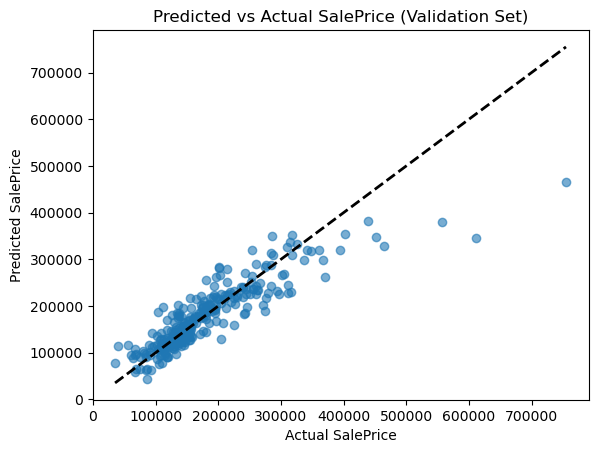

In [31]:
import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice (Validation Set)")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'k--', lw=2)  # reference line
plt.show()


Model predicts moderately priced homes well.
Underestimates high-priced homes, which inflates RMSE relative to MAE. To hopefully be able to estimate homes with high prices better, we will take a look at what happens when we log transform sales prices

In [32]:
import numpy as np

# Apply log transformation
train_df['log_SalePrice'] = np.log(train_df['SalePrice'])
val_df['log_SalePrice'] = np.log(val_df['SalePrice'])


In [33]:
formula_log = """
log_SalePrice ~ LotArea + YearBuilt + GrLivArea + FullBath + HalfBath
                 + C(Neighborhood)
"""

In [34]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

glm_log = smf.glm(
    formula=formula_log,
    data=train_df,
    family=sm.families.Gaussian()
).fit()

print(glm_log.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          log_SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1138
Model Family:                Gaussian   Df Model:                           29
Link Function:               Identity   Scale:                        0.034340
Method:                          IRLS   Log-Likelihood:                 326.80
Date:                Mon, 15 Dec 2025   Deviance:                       39.079
Time:                        21:55:12   Pearson chi2:                     39.1
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9687
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
# Predict log(SalePrice) on validation
val_pred_log = glm_log.predict(val_df)

# Back-transform to original SalePrice scale
val_pred = np.exp(val_pred_log)


In [36]:
glm_log = smf.glm(
    formula=formula_log,
    data=val_df,
    family=sm.families.Gaussian()
).fit()

print(glm_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          log_SalePrice   No. Observations:                  292
Model:                            GLM   Df Residuals:                      262
Model Family:                Gaussian   Df Model:                           29
Link Function:               Identity   Scale:                        0.035102
Method:                          IRLS   Log-Likelihood:                 90.525
Date:                Mon, 15 Dec 2025   Deviance:                       9.1967
Time:                        21:55:13   Pearson chi2:                     9.20
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9880
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = val_df['SalePrice']
y_pred = val_pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)
print("Validation R²:", r2)


Validation RMSE: 37500.49237717763
Validation MAE: 24719.63882245274
Validation R²: 0.8166587847055239


The model performs slightly better with log transformed sales prices

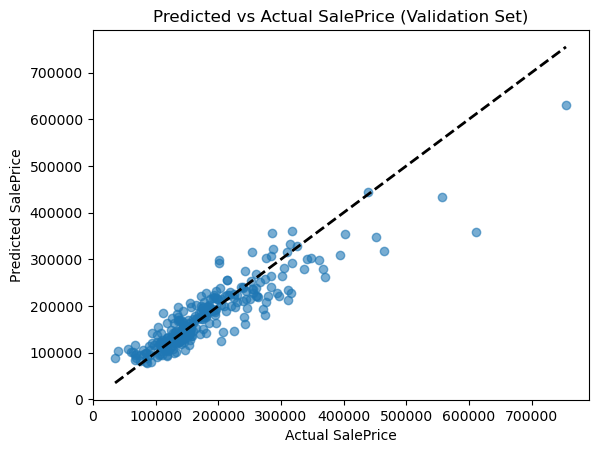

In [38]:
# Plot residuals of model with log transformed Sales Prices
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs Actual SalePrice (Validation Set)")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'k--', lw=2)  # reference line
plt.show()


In [39]:
# Print AIC
print("Model AIC:", glm_model.aic)

Model AIC: 28004.236386935525


/var/folders/x_/zccbsk657rb51hx1tc0t1ss80000gn/T/ipykernel_61802/2142532545.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")


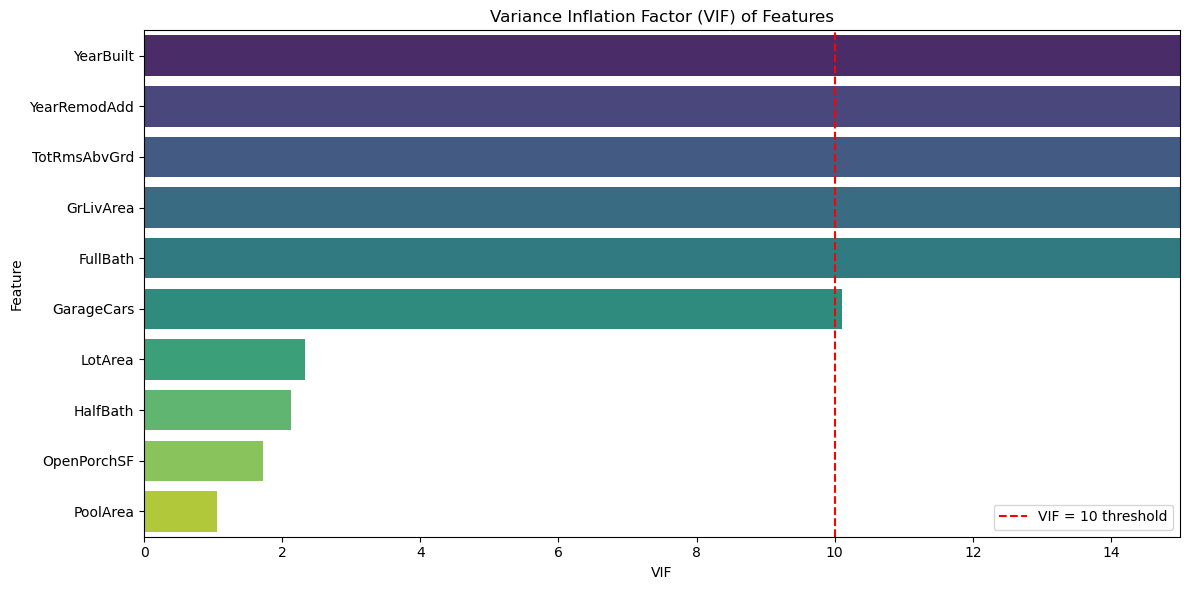

In [40]:
#  Visualize VIFs
# Sort VIFs descending for better visualization
vif_sorted = vif_df.sort_values("VIF", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="VIF", y="feature", data=vif_sorted, palette="viridis")
plt.axvline(10, color='red', linestyle='--', label='VIF = 10 threshold')
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.title("Variance Inflation Factor (VIF) of Features")
plt.xlim(0, 15)  # Set x-axis scale from 0 to 15
plt.legend()
plt.tight_layout()
plt.show()


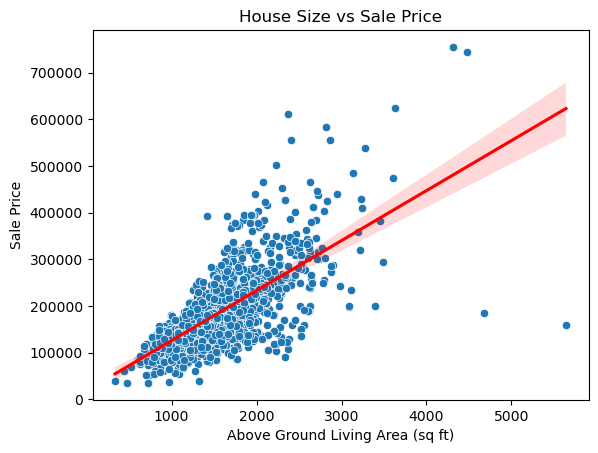

In [41]:
# Vizualize sales price vs living area
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data)
sns.regplot(x='GrLivArea', y='SalePrice', data=data, scatter=False, color='red')
plt.title('House Size vs Sale Price')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Sale Price')
plt.show()

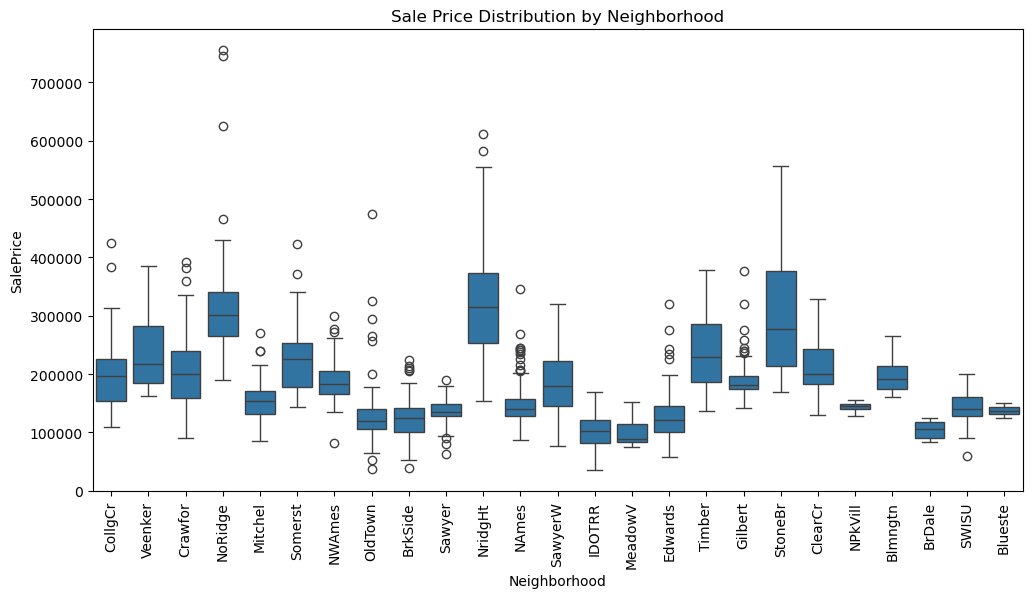

In [42]:
# Visualize sales price by neighborhood
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

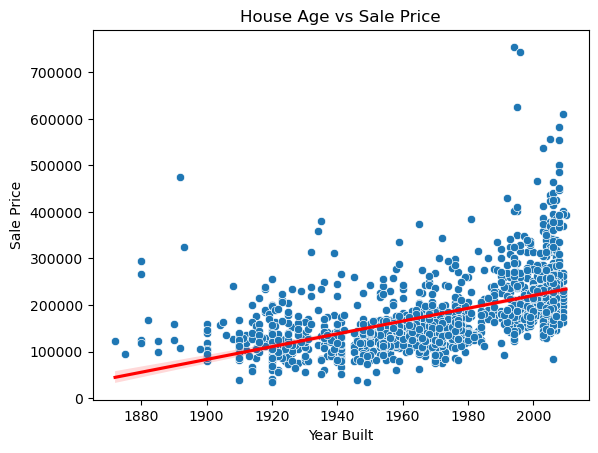

In [43]:
# Visualize House Price vs Year Built
sns.scatterplot(x='YearBuilt', y='SalePrice', data=data)
sns.regplot(x='YearBuilt', y='SalePrice', data=data, scatter=False, color='red')
plt.title('House Age vs Sale Price')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.show()

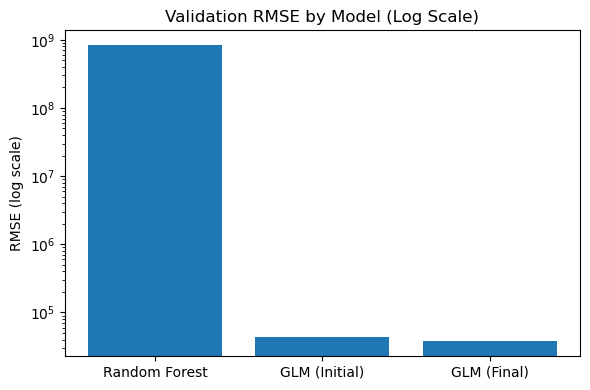

In [44]:
# Visualizing model comparison:
import matplotlib.pyplot as plt

models = ['Random Forest', 'GLM (Initial)', 'GLM (Final)']
rmse = [834463000.78, 42935.4, 37500.5]

plt.figure(figsize=(6,4))
plt.bar(models, rmse)
plt.yscale('log')
plt.title('Validation RMSE by Model (Log Scale)')
plt.ylabel('RMSE (log scale)')
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd

data = {
    "Model": [
        "Model 1 (Random Forest)",
        "Model 2 (GLM)",
        "Final Model (GLM)"
    ],
    "AIC": [
        None,
        27619.86,
        24554.73
    ],
    "Validation RMSE": [
        834463000.78,
        42935.4,
        37500.5
    ],
    "Validation R²": [
        0.89,
        0.76,
        0.82
    ]
}

df = pd.DataFrame(data)
print(df.to_markdown(index=False))

| Model                   |     AIC |   Validation RMSE |   Validation R² |
|:------------------------|--------:|------------------:|----------------:|
| Model 1 (Random Forest) |   nan   |       8.34463e+08 |            0.89 |
| Model 2 (GLM)           | 27619.9 |   42935.4         |            0.76 |
| Final Model (GLM)       | 24554.7 |   37500.5         |            0.82 |


The model still struggles to predict prices for higher priced houses, but performs slightly better